# Museum Attendance vs City Population

This notebook reads the `museum_city_features` table (populated by the pipeline)
and visualises the log-log regression model (power-law fit).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text
from dotenv import load_dotenv

load_dotenv(override=True)

from wikiapp.db import get_engine, get_session
from wikiapp.train import load_latest_model, summary_from_db

sns.set_theme(style="whitegrid")
engine = get_engine()

## 1. Load Data

In [2]:
with get_session(engine) as session:
    df = pd.read_sql(
        text("SELECT museum_name, city, country, annual_visitors, population FROM museum_city_features"),
        session.connection(),
    )
print(f"{len(df)} museums in feature table")
df.head(10)

61 museums in feature table


,museum_name,city,country,annual_visitors,population
0,Louvre,Paris,France,900000020251,2145906
1,National Museum of China,Beijing,China,695680020242,21893095
2,Vatican Museums,"Vatican City , Rome",Vatican,682543620243,882
3,Shenzhen Museum,Shenzhen,China,680500020244,17681600
4,British Museum,London,United Kingdom,647995220245,8908081
5,China Science and Technology Museum,Beijing,China,642100020246,21893095
6,"Natural History Museum, South Kensington",London,United Kingdom,630197220247,8908081
7,Metropolitan Museum of Art,New York City,United States,572024258,8804190
8,Nanjing Museum,Nanjing,China,568000020249,9314685
9,American Museum of Natural History,New York City,United States,54000002024,8804190


## 2. Distributions

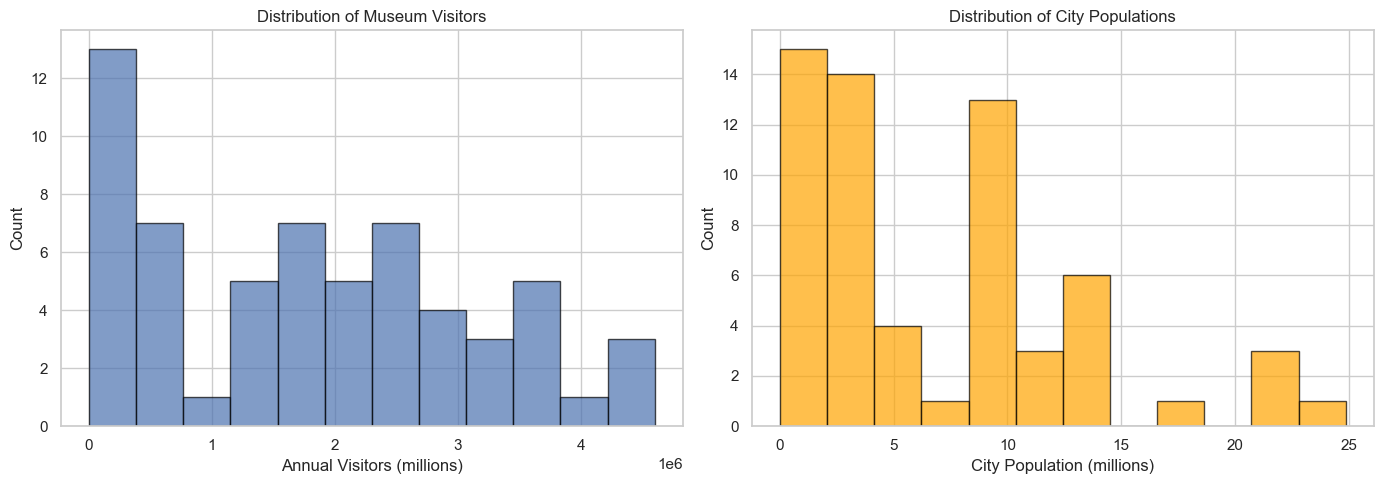

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["annual_visitors"] / 1e6, bins=12, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Annual Visitors (millions)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Museum Visitors")

axes[1].hist(df["population"] / 1e6, bins=12, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_xlabel("City Population (millions)")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of City Populations")

plt.tight_layout()
plt.show()

## 3. Regression

In [ ]:
model, version = load_latest_model(engine)
metrics = summary_from_db(engine)
print(f"Model version: {version}")
print(f"R² = {metrics['r2']:.4f}  |  RMSE = {metrics['rmse']:,.0f}  |  MAE = {metrics['mae']:,.0f}")
coef, intercept = float(model.coef_[0]), float(model.intercept_)
print(f"log(visitors) = {coef:.4f} * log(population) + {intercept:.4f}")
print(f"  → visitors = e^{intercept:.4f} × population^{coef:.4f}")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(df["population"] / 1e6, df["annual_visitors"] / 1e6,
           s=80, alpha=0.7, edgecolors="black", linewidths=0.5, zorder=5)

for _, row in df.iterrows():
    ax.annotate(row["museum_name"],
                (row["population"] / 1e6, row["annual_visitors"] / 1e6),
                fontsize=7, alpha=0.8, xytext=(5, 5), textcoords="offset points")

# Log-log regression curve in original space
x_range = np.linspace(df["population"].min(), df["population"].max(), 200)
y_range = np.exp(model.predict(np.log(x_range).reshape(-1, 1)))
ax.plot(x_range / 1e6, y_range / 1e6, color="red", linewidth=2,
        label=f"log-log: visitors = e^{intercept:.2f} × pop^{coef:.2f}\nR² = {metrics['r2']:.4f}")

ax.set_xlabel("City Population (millions)", fontsize=12)
ax.set_ylabel("Annual Museum Visitors (millions)", fontsize=12)
ax.set_title("Museum Visitors vs City Population — Log-Log Regression", fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

## 4. Residual Analysis

In [ ]:
df["predicted"] = np.exp(model.predict(np.log(df[["population"]].to_numpy(dtype=float))))
df["residual"] = df["annual_visitors"] - df["predicted"]

fig, ax = plt.subplots(figsize=(10, 5))
colors = ["green" if r > 0 else "red" for r in df["residual"]]
ax.barh(df["museum_name"], df["residual"] / 1e6, color=colors, alpha=0.7)
ax.set_xlabel("Residual (millions of visitors)")
ax.set_title("Residuals: Actual − Predicted Visitors")
ax.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

## Interpretation

- **Log-log model**: `log(visitors) = coef × log(population) + intercept` captures a power-law relationship, which is a better fit for this kind of data than a plain linear model.
- **Positive residuals** (green): museums that outperform their city population prediction, driven by international tourism, free admission, or iconic status.
- **Negative residuals** (red): museums below prediction — possibly in cities with many competing museums or less international draw.

### Potential Next Steps
- Add features (GDP, tourism arrivals, museum type, free-admission flag)
- Aggregate museums by city for a city-level analysis
- Use cross-validation with a larger dataset